In [1]:
import pandas as pd 
import numpy as np

#### Datensatz einlesen

Der folgende Datensatz enthält verschiedene Features zur Vorhersage, ob ein Patient an einer Herzerkrankung erkrankt ist  (target=0) oder gesunde ist (target=1).

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Aufgabe 1

#### a) Analyse der Zielvariable

Untersuchen Sie die Verteilung der Zielvariablen 'target'.

In [4]:
y = df['target']
y.value_counts(sort=False)

0    138
1    165
Name: target, dtype: int64

#### b)  Visualisierung der Altersverteilung

Zeichnen Sie ein Histogramm der Altersverteilung. Zeichnen Sie anschließend Histogramme der Altersverteilung derjenigen Patienten mit 'target=0' (herzkrank) und 'target=1' (gesund). Verwenden Sie dazu die Funktion <a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html">matplotlib.pyplot.hist<a/>.

In [5]:
import matplotlib.pyplot as plt

In [6]:
df_target1 = df[df['target'] == 1]
df_target0 = df[df['target'] == 0]

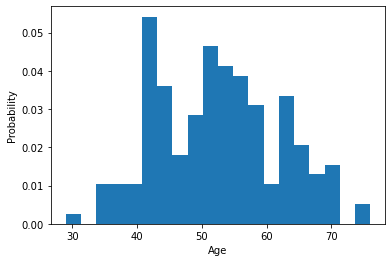

In [7]:
%matplotlib inline

plt.hist(df_target1['age'], density=True, bins=20)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Age');

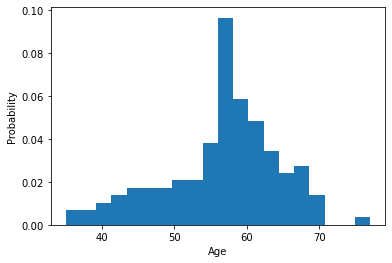

In [8]:
%matplotlib inline

plt.hist(df_target0['age'], density=True, bins=20)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Age');

#### c) Datenvorbereitung

Spalten Sie die Zielvariable **target** ab und splitten Sie die Daten anschließend in einen Trainings- und einen Testdatensatz auf (20% Test, 80% Train).

In [9]:
from sklearn.model_selection import train_test_split

#X_train, X_test = train_test_split(df, test_size=0.2, random_state=0)
#X_train = X_train.copy()
#X_test = X_test.copy()
#y_train = X_train['target']
#y_test = X_test['target']
#X_train = X_train.drop('target', axis=1)
#X_test = X_test.drop('target', axis=1)

y = df['target']
X =  df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#### d) Training eines RandomForest

Trainieren Sie einen <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a> in Scikit-learn mit den Parametern **n_estimators=20**, **max_depth=1** und **min_samples_leaf = 2**. 

Hinweis: es wird in dieser Übung darauf verzichtet, die Hyperparameter zu optimieren. Grundsätzlich wäre dies jedoch sinnvoll.

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=20, max_depth=1, min_samples_leaf = 2, random_state = 0)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=1, min_samples_leaf=2, n_estimators=20,
                       random_state=0)

#### e) Modellvalidierung

Bestimmen Sie jeweils den ROC-AUC-Score und die Accuracy auf dem Trainings- und auf dem Testdatensatz. Wie bewerten Sie die Güte des Modells?

In [11]:
from sklearn.metrics import confusion_matrix

def stats(true, pred):
    c = confusion_matrix(true, pred)
    #print("Confusion Matrix: \n", c)

    TP = c[0][0]
    FP = c[0][1]
    FN = c[1][0]
    TN = c[1][1]

    #print("TN:", TN, "TP:",TP,"FN:",FN,"FP:",FP)

    acc = (TP+TN)/(TP+TN+FP+FN)

    #print("Accuracy: \n", acc)

    recall = TP/(TP+FN)

    #print("Recall: \n",recall)

    precision = TP/(TP+FP)

    #print("Precision: \n",precision)
    
    return acc, recall, precision, c

In [12]:
from sklearn import metrics

ROC_AUC_score_train = metrics.roc_auc_score(y_train, clf.predict(X_train))
ROC_AUC_score_test = metrics.roc_auc_score(y_test, clf.predict(X_test))


print("ROC_AUC_scores: \nTrain| ", ROC_AUC_score_train, "\nTest | ", ROC_AUC_score_test)

acc_train, r_tr, pre_tr, c_tr= stats(y_train, clf.predict(X_train))
acc_test, r_te, pre_te, c_te = stats(y_test, clf.predict(X_test))
print("Accuracy: \nTrain| ", acc_train, "\nTest | ", acc_test)

ROC_AUC_scores: 
Train|  0.79966989890654 
Test |  0.8262527233115468
Accuracy: 
Train|  0.8099173553719008 
Test |  0.8360655737704918


#### f) Feature-Importances

Bestimmen Sie die Feature-Importances für alle Features. Welche fünf Features haben die höchste Feature-Importance?

In [13]:
# iterating the columns
feature_names = []
for col in X_train.columns:
    feature_names.append(col)

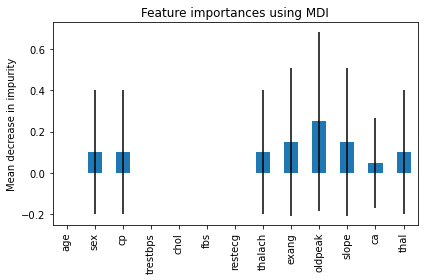

In [14]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Elapsed time to compute the importances: 1.545 seconds


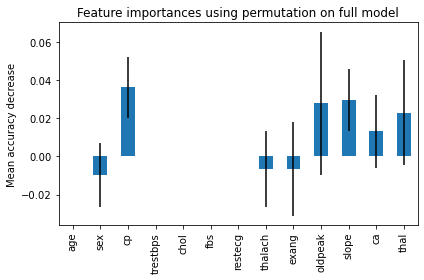

In [15]:
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### g) Training eines Decision Trees

Trainieren Sie nun einen Decision Tree mit den Parametern **max_depth=1** und **min_samples_leaf = 2**. Berechnen Sie erneut die Accuracy und den ROC_AUC_SCORE jeweils für Train und Test. Vergleichen Sie die Ergebnisse mit den Ergebnissen des RandomForest.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

cl = DecisionTreeClassifier(max_depth=1, min_samples_leaf=2)

cl = cl.fit(X_train, y_train)

In [17]:
ROC_AUC_score_train_decTree = metrics.roc_auc_score(y_train, cl.predict(X_train))
ROC_AUC_score_test_decTree = metrics.roc_auc_score(y_test, cl.predict(X_test))

print("----- ROC_AUC_scores -----\nRandomForest: \nTrain| ", ROC_AUC_score_train, "\nTest | ", ROC_AUC_score_test,"\nDecisionTree:\nTrain| ", ROC_AUC_score_train_decTree, "\nTest | ", ROC_AUC_score_test_decTree)

dec_acc_train, r_tr, pre_tr, c_tr= stats(y_train, cl.predict(X_train))
dec_acc_test, r_te, pre_te, c_te = stats(y_test, clf.predict(X_test))
print("----- Accuracy -----\nRandomForest: \nTrain| ", acc_train, "\nTest | ", acc_test,"\nDecisionTree:\nTrain| ", dec_acc_train, "\nTest | ", dec_acc_test)


----- ROC_AUC_scores -----
RandomForest: 
Train|  0.79966989890654 
Test |  0.8262527233115468 
DecisionTree:
Train|  0.752424179905096 
Test |  0.7821350762527233
----- Accuracy -----
RandomForest: 
Train|  0.8099173553719008 
Test |  0.8360655737704918 
DecisionTree:
Train|  0.7520661157024794 
Test |  0.8360655737704918


## Aufgabe 2

In dieser Aufgabe soll für den obigen Datensatz ein Klassifikationsmodell basierend auf einem Support Vetor Classifier entwickelt werden.

#### a) Training eines Support Vector Classifiers

Trainieren Sie nun einen Support Vector Classifier in Scikit-learn unter Verwendung des Gauß-Kernels (kernel='rbf'). Bestimmen Sie anschließend die Accuracy auf dem Trainings- und auf dem Testdatensatz und vergleichen Sie diese mit den Ergebnissen des RandomForest. Wie erklären Sie Ihre Beobachtung?

In [29]:
from sklearn.svm import SVC
svc_model = SVC(kernel="rbf")
svc_model.fit(X_train,y_train)

acc_svc_train, _, _, _ = stats(y_train, svc_model.predict(X_train))
acc_svc_test, _, _, _ = stats(y_test, svc_model.predict(X_test))

print("----- Accuracy -----\nRandomForest: \nTrain| ", acc_train, "\nTest | ", acc_test,"\nSVC:\nTrain| ", acc_svc_train, "\nTest | ", acc_svc_test)

----- Accuracy -----
RandomForest: 
Train|  0.8099173553719008 
Test |  0.8360655737704918 
SVC:
Train|  0.6652892561983471 
Test |  0.6885245901639344


#### b) SVC mit Standardisierung

Wiederholen Sie Teilaufgabe a), aber wenden Sie vorher einen StandardScaler an. Wie erklären Sie Ihre Beobachtung?

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline(steps = [
    ("Scaler", StandardScaler()),
    ("SVM", SVC(kernel='rbf'))])

pipe.fit(X_train, y_train)

acc_pipe_train, _, _, _ = stats(y_train, pipe.predict(X_train))
acc_pipe_test, _, _, _ = stats(y_test, pipe.predict(X_test))

print("----- Accuracy -----\nRandomForest: \nTrain| ", acc_train, "\nTest | ", acc_test,"\nSVC:\nTrain| ", acc_svc_train, "\nTest | ", acc_svc_test,"\nSVC_Pipe:\nTrain| ", acc_pipe_train, "\nTest | ", acc_pipe_test)

----- Accuracy -----
RandomForest: 
Train|  0.8099173553719008 
Test |  0.8360655737704918 
SVC:
Train|  0.6652892561983471 
Test |  0.6885245901639344 
SVC_Pipe:
Train|  0.8925619834710744 
Test |  0.8688524590163934


#### c) Hyperparameteroptimierung

Optimieren Sie nun die Hyperparameter C und gamma des Support Vector Classifiers. Legen Sie dazu eine Pipeline bestehend aus einem StandardScaler und einem Support Vector Classifier an und verwenden Sie diese innerhalb einer GridSearch mit fünffacher Cross Validation. Testen Sie für den Parameter C die Werte 0.01, 0.1, 1 und 10 und für den Parameter gamma die Werte 0.001, 0.01, 0.1, 1 und 10.

In [38]:
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV

with parallel_backend('threading', n_jobs=16):
    param_grid = [
      {'SVM__C': [0.01, 0.1, 1, 10], 'SVM__gamma': [0.001, 0.01, 0.1, 1, 10]}
     ]
    svc = SVC(kernel='rbf')

    gs = GridSearchCV(pipe, param_grid=param_grid)
    gs.fit(X_train, y_train)
    
gs.best_params_

{'SVM__C': 10, 'SVM__gamma': 0.001}

#### d) Modellbewertung

Vergleichen Sie das Modell, das sich aus den optimalen Parametern ergibt mit dem RandomForest, indem Sie wieder die Accuracy auf den Trainingsdaten und auf den Testdaten berechnen. Wie lautet Ihr Fazit?

In [39]:
pipe.set_params(**gs.best_params_)
pipe.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('SVM', SVC(C=10, gamma=0.001))])

In [41]:
acc_opt_train, _, _, _ = stats(y_train, pipe.predict(X_train))
acc_opt_test, _, _, _ = stats(y_test, pipe.predict(X_test))

print("----- Accuracy -----\nRandomForest: \nTrain| ", acc_train, "\nTest | ", acc_test,"\nSVC:\nTrain| ", acc_svc_train, "\nTest | ", acc_svc_test,"\nSVC_Pipe:\nTrain| ", acc_pipe_train, "\nTest | ", acc_pipe_test,"\nSVC_Pipe_Optimiert:\nTrain| ", acc_opt_train, "\nTest | ", acc_opt_test)

----- Accuracy -----
RandomForest: 
Train|  0.8099173553719008 
Test |  0.8360655737704918 
SVC:
Train|  0.6652892561983471 
Test |  0.6885245901639344 
SVC_Pipe:
Train|  0.8925619834710744 
Test |  0.8688524590163934 
SVC_Pipe_Optimiert:
Train|  0.8347107438016529 
Test |  0.8360655737704918
